<a href="https://colab.research.google.com/github/12860/Python-projects/blob/master/mystyle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.Setup

## 1.1 Download images

In [0]:

import os
img_dir = '/tmp/nst'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

1.2 import and configure modules

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize']=(10,10)
mpl.rcParams['axes.grid']=False

import numpy as np
from PIL import Image
import time
import functools

import tensorflow as tf 
import tensorflow.contrib.eager as tfe 

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K 

tf.enable_eager_execution()
print("Eager execution : {}".format(tf.executing_eagerly()))





Eager execution : True


In [0]:
# Set up some global values here
content_path = '/tmp/nst/Green_Sea_Turtle_grazing_seagrass.jpg'
style_path = '/tmp/nst/The_Great_Wave_off_Kanagawa.jpg'

# 2. visualize the input

In [0]:
def load_img(path_to_img):
    max_dim=512
    img = Image.open(path_to_img)
    long =max(img.size)
    scale =max_dim/long
    #img =img.resize(round(img.size[0]*scale),round(img.size[1])*scale,Image.ANTIALIAS)
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)

    img =kp_image.img_to_array(img)

    img =np.expand_dims(img,axis=0)
    return img

def imshow(img,title=None):
    #remove the batch dimension
    out = np.squeeze(img,axis=0)
    #Normalize for display
    out =out.astype('uint8')
    #plt.show(out)
    plt.imshow(out)
    if title is not None:
        plt.title(title)
    plt.imshow(out)
    



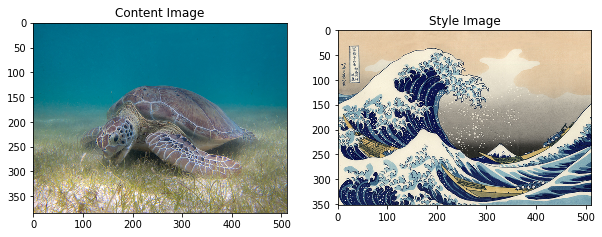

In [7]:
plt.figure(figsize=(10,10))

#content =load_img(content_path).astype('uint8')

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

#  3. prepare the data

In [0]:
def load_and_process_img(path_to_img):
    img = load_img(path_to_img)
    img = tf.keras.application.vgg19.preprocess_input(img)
    return img

def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) ==4:
        x=np.squeeze(x,0)
    assert len(x.shape) ==3,("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape)!= 3:
        raise ValueError("Invalid input to deprocessing img")

    #perform the inverse of the preprocessing step
    x[:,:,0]+=103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x=np.clip(x,0,255).astype('uint8')
    return x

# 4. define content and style  representations

In [0]:
conten_layers = ['block5_conv2']

# Style layer we use
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
                ]

num_content_layers = len(conten_layers)
num_style_layers = len(style_layers)

# 5. build the model

In [0]:
def get_model():
    # load pretrained VGG
    vgg = kf.keras.application.vgg19.VGG19(include_to=False
        ,weights='imagenet')
    vgg.trainable =False

    #get output layers conresponding to style and content layers
    style_outputs=[vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    # Build model
    return models.Model(vgg.input,model_outputs)

# 6.define loss functions

In [0]:
def get_content_loss(base_content,target):
    return tf.reduce_mean(tf.square(base_content-target))

def gram_matrix(input_tensor):
    #we make the image channels first
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor,[-1,channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a,a,transpose_a=True)
    return gram/ tf.cast(n,tf.float32)

def get_style_loss(base_style,gram_target):
    # Expect two images of dimension h w c

    height,width,channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)

    return tf.reduce_mean(tf.square(gram_style-gram_target))

# 7.apply style transfer to our images
## 7.1 run gradient descent

In [0]:
def get_feature_representations(model,content_path,style_path):
    # load image
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)

    # batch compute content and style features
    style_outputs =model(style_image)
    content_outputs =model(content_image)

    # get the style and content feature representations 
    style_features = [style_layer[0] for style_layers in style_outputs[:num_style_layers]]
    content_features =[content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features,content_features

## 7.2 computing the loss and gradients

In [17]:

# 7.2 computing the loss and gradients

def compute_loss(model,loss_weights,inti_image,gram_style_features,content_features):
    style_weight,content_weight = loss_weights

    model_outputs =model(inti_image)

    style_output_features =model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    #accumulate style losses from all layers
    #here ,we equally weight each contribution of each loss layer
    weight_per_style_layer = 1.0 /float(num_style_layers)
    for target_style,comb_style in zip(gram_style_features,style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0],target_style)

    #accumulate content losses from all layers
    weight_per_style_layer =1.0/float(num_content_layers)
    #for target_content,comb_content in zip(content_features,content_output_features):
    #    content_score += weight_per_style_layer * get_content_loss(comb_content[0],target_content)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)

    style_score * = style_weight
    content_score * =content_weight

    # get total loss
    loss = style_score +content_score
    return loss,style_score,content_score



SyntaxError: ignored

In [0]:
# 7.3 then computing the gradients 
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss =compute_loss(**cfg)
    total_loss =all_loss[0]
    return tape.gradient(total_loss,cfg['inti_image']),all_loss